In [67]:
import sys
sys.path.append("..")
from argparse import Namespace
from data import BavarianCrops, BreizhCrops, SustainbenchCrops, ModisCDL
from torch.utils.data import DataLoader

In [68]:
args = Namespace(
    sequencelength=70,
    dataroot = "/data/sustainbench",
    device="cuda",
    dataset = "ghana"
)

dataroot = args.dataroot

from earlyrnn import EarlyRNN
nclasses = 4
input_dim = 12
model = EarlyRNN(nclasses=nclasses, input_dim=input_dim).to(args.device)
import torch
model.load_state_dict(torch.load("../snapshots/sustainbenchghanamodel.pth"))
model.eval()

EarlyRNN(
  (intransforms): Sequential(
    (0): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=12, out_features=64, bias=True)
  )
  (backbone): LSTM(64, 64, num_layers=2, bias=False, batch_first=True, dropout=0.2)
  (classification_head): ClassificationHead(
    (projection): Sequential(
      (0): Linear(in_features=64, out_features=4, bias=True)
      (1): LogSoftmax(dim=2)
    )
  )
  (stopping_decision_head): DecisionHead(
    (projection): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
)

In [69]:
train_ds = SustainbenchCrops(root=dataroot,partition="train", sequencelength=args.sequencelength, country=args.dataset)
test_ds = SustainbenchCrops(root=dataroot,partition="test", sequencelength=args.sequencelength, country=args.dataset)

expecting folder /data/sustainbench/africa_crop_type_mapping_v1.0 to exist
partition train. selecting 2260/2881 tiles
preprocessing dataset (iterating through tiles taking s2 data and aggregating pixels of each field)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2260/2260 [10:36<00:00,  3.55it/s]


expecting folder /data/sustainbench/africa_crop_type_mapping_v1.0 to exist
partition test. selecting 323/2881 tiles
preprocessing dataset (iterating through tiles taking s2 data and aggregating pixels of each field)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [01:34<00:00,  3.43it/s]


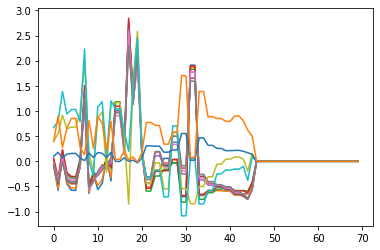

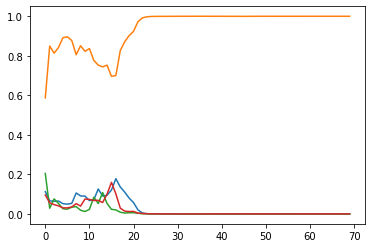

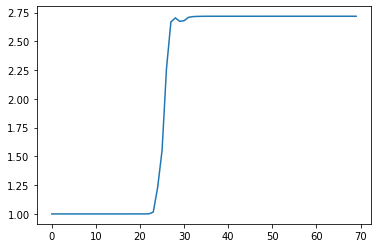

In [22]:
X,y = test_ds[0]
X = X.unsqueeze(0).to(args.device)
log_class_probabilities, probability_stopping = model(X)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(X[0].cpu().detach())
plt.figure()
plt.plot(log_class_probabilities[0].cpu().detach().exp())
plt.figure()
plt.plot(probability_stopping[0].cpu().detach().exp())

In [24]:
import numpy as np
from tqdm.notebook import tqdm
dataloader = DataLoader(test_ds, batch_size=16)
device = args.device
model.eval()

stats = []
losses = []
for batch in tqdm(dataloader):
    X, y_true = batch
    X, y_true = X.to(device), y_true.to(device)

    log_class_probabilities, probability_stopping, predictions_at_t_stop, t_stop = model.predict(X)
    stat = {}
    stat["probability_stopping"] = probability_stopping.cpu().detach().numpy()
    stat["class_probabilities"] = log_class_probabilities.exp().cpu().detach().numpy()
    stat["predictions_at_t_stop"] = predictions_at_t_stop.unsqueeze(-1).cpu().detach().numpy()
    stat["t_stop"] = t_stop.unsqueeze(-1).cpu().detach().numpy()
    stat["targets"] = y_true.cpu().detach().numpy()

    stats.append(stat)


# list of dicts to dict of lists
stats = {k: np.vstack([dic[k] for dic in stats]) for k in stats[0]}

  0%|          | 0/61 [00:00<?, ?it/s]

In [25]:
y_pred = stats["predictions_at_t_stop"][:,0]
y_true = stats["targets"][:,0]

In [26]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_true, y_pred))

accuracy_score(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.88      0.70      0.78       201
           1       0.83      0.92      0.87       489
           2       0.88      0.90      0.89       155
           3       0.82      0.74      0.78       130

    accuracy                           0.85       975
   macro avg       0.85      0.81      0.83       975
weighted avg       0.85      0.85      0.84       975



0.8451282051282051